In [13]:
# ============================================================
# 1. MOUNT GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

# ============================================================
# 2. IMPORT LIBRARIES
# ============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D,
    Concatenate, Multiply
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# ============================================================
# 3. GPU CONFIGURATION
# ============================================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPU Available:", gpus)

# ============================================================
# 4. PARAMETERS & PATHS
# ============================================================
BASE_DIR = "/content/drive/MyDrive/ML_Dataset"
DATASET_1 = os.path.join(BASE_DIR, "ML_Dataset_1")
DATASET_2 = os.path.join(BASE_DIR, "ML_Dataset_2")

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# ============================================================
# 5. COLLECT IMAGE PATHS
# ============================================================
def collect_images(datasets):
    data = []
    for base in datasets:
        for cls in ['normal', 'osteoporosis']:
            label = 0 if cls == 'normal' else 1
            folder = os.path.join(base, cls)
            for f in os.listdir(folder):
                data.append([os.path.join(folder, f), label])
    return pd.DataFrame(data, columns=['path', 'label'])

df = collect_images([DATASET_1, DATASET_2])
print(df['label'].value_counts())

# ============================================================
# 6. STRATIFIED SPLIT
# ============================================================
train_df, temp_df = train_test_split(
    df, test_size=0.30, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df['label'], random_state=42
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
label
1    421
0    407
Name: count, dtype: int64


In [14]:
# ============================================================
# 7. CLAHE PREPROCESSING
# ============================================================
def clahe_preprocess(img):
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    enhanced = clahe.apply(gray)
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
    return enhanced / 255.0

# ============================================================
# 8. DATA GENERATORS
# ============================================================
train_datagen = ImageDataGenerator(
    preprocessing_function=clahe_preprocess,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)
test_datagen = ImageDataGenerator(preprocessing_function=clahe_preprocess)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=True
)

val_gen = test_datagen.flow_from_dataframe(
    val_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='path', y_col='label',
    target_size=IMG_SIZE, batch_size=1,
    class_mode='raw', shuffle=False
)

# ============================================================
# 9. SE ATTENTION BLOCK
# ============================================================
def se_block(x, ratio=16):
    filters = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([x, se])

# ============================================================
# 10. HYBRID MODEL (DenseNet + EfficientNet)
# ============================================================
input_tensor = Input(shape=(*IMG_SIZE, 3))

densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
effnet   = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

for layer in densenet.layers:
    layer.trainable = False
for layer in effnet.layers:
    layer.trainable = False

dn_feat = se_block(densenet.output)
dn_feat = GlobalAveragePooling2D()(dn_feat)

ef_feat = se_block(effnet.output)
ef_feat = GlobalAveragePooling2D()(ef_feat)

merged = Concatenate()([dn_feat, ef_feat])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=input_tensor, outputs=output)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Found 579 validated image filenames.
Found 124 validated image filenames.
Found 125 validated image filenames.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 12,015,732 (45.84 MB)

 Trainable params: 928,657 (3.54 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

In [15]:
# ============================================================
# 11. CALLBACK: VAL PRECISION / RECALL / F1 PER EPOCH
# ============================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ValMetricsPerEpoch(tf.keras.callbacks.Callback):
    def __init__(self, val_gen):
        super().__init__()
        self.val_gen = val_gen

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        y_true, y_pred = [], []

        # IMPORTANT: limit iteration to ONE validation epoch
        for i in range(len(self.val_gen)):
            images, labels = self.val_gen[i]

            preds = self.model.predict(images, verbose=0)
            preds = (preds >= 0.5).astype(int).ravel()

            y_true.extend(labels.astype(int).ravel())
            y_pred.extend(preds)

        logs['val_precision_sklearn'] = precision_score(y_true, y_pred, zero_division=0)
        logs['val_recall_sklearn']    = recall_score(y_true, y_pred, zero_division=0)
        logs['val_f1_sklearn']        = f1_score(y_true, y_pred, zero_division=0)

        print(
            f"\n[Val@Epoch {epoch+1}] "
            f"Precision={logs['val_precision_sklearn']:.4f} | "
            f"Recall={logs['val_recall_sklearn']:.4f} | "
            f"F1={logs['val_f1_sklearn']:.4f}"
        )


metrics_cb = ValMetricsPerEpoch(val_gen)

# ============================================================
# 12. OTHER CALLBACKS
# ============================================================
checkpoint = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/best_hybrid_model.h5",
    monitor='val_loss', save_best_only=True, verbose=1
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1
)

callbacks = [checkpoint, early_stop, reduce_lr, metrics_cb]

In [16]:
# ============================================================
# 13. TRAINING STAGE 1
# ============================================================
history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5214 - loss: 0.7131
Epoch 1: val_loss improved from inf to 0.64160, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 1] Precision=0.6277 | Recall=0.9365 | F1=0.7516
37/37 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.5223 - loss: 0.7123 - val_accuracy: 0.6855 - val_loss: 0.6416 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6277 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7516
Epoch 2/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.6897 - loss: 0.6193
Epoch 2: val_loss did not improve from 0.64160

[Val@Epoch 2] Precision=0.5980 | Recall=0.9683 | F1=0.7394
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 822ms/step - accuracy: 0.6897 - loss: 0.6191 - val_accuracy: 0.6532 - val_loss: 0.6673 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.5980 - val_recall_sklearn: 0.9683 - val_f1_sklearn: 0.7394
Epoch 3/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.6774 - loss: 0.6113
Epoch 3: val_loss improved from 0.64160 to 0.63025, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 3] Precision=0.6383 | Recall=0.9524 | F1=0.7643
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 944ms/step - accuracy: 0.6777 - loss: 0.6109 - val_accuracy: 0.7016 - val_loss: 0.6303 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6383 - val_recall_sklearn: 0.9524 - val_f1_sklearn: 0.7643
Epoch 4/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.7019 - loss: 0.5824
Epoch 4: val_loss improved from 0.63025 to 0.58608, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 4] Precision=0.6552 | Recall=0.9048 | F1=0.7600
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 919ms/step - accuracy: 0.7021 - loss: 0.5823 - val_accuracy: 0.7097 - val_loss: 0.5861 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6552 - val_recall_sklearn: 0.9048 - val_f1_sklearn: 0.7600
Epoch 5/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7193 - loss: 0.5520
Epoch 5: val_loss did not improve from 0.58608

[Val@Epoch 5] Precision=0.6629 | Recall=0.9365 | F1=0.7763
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 853ms/step - accuracy: 0.7195 - loss: 0.5521 - val_accuracy: 0.7258 - val_loss: 0.5932 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6629 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7763
Epoch 6/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.7382 - loss: 0.5701
Epoch 6: val_loss improved from 0.58608 to 0.57389, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 6] Precision=0.6591 | Recall=0.9206 | F1=0.7682
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 943ms/step - accuracy: 0.7381 - loss: 0.5697 - val_accuracy: 0.7177 - val_loss: 0.5739 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6591 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7682
Epoch 7/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.7318 - loss: 0.5477
Epoch 7: val_loss did not improve from 0.57389

[Val@Epoch 7] Precision=0.6629 | Recall=0.9365 | F1=0.7763
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 857ms/step - accuracy: 0.7317 - loss: 0.5480 - val_accuracy: 0.7258 - val_loss: 0.5774 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6629 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7763
Epoch 8/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7434 - loss: 0.5601
Epoch 8: val_loss did not improve from 0.57389

[Val@Epoch 8] Precision=0.6629 | Recall=0.9365 | F1=0.7763
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 822ms/step - accuracy: 0.7435 - loss: 0.5593 - val_accuracy


[Val@Epoch 9] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 927ms/step - accuracy: 0.7437 - loss: 0.5635 - val_accuracy: 0.7419 - val_loss: 0.5458 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 10/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7377 - loss: 0.5129
Epoch 10: val_loss did not improve from 0.54581

[Val@Epoch 10] Precision=0.6629 | Recall=0.9365 | F1=0.7763
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 846ms/step - accuracy: 0.7376 - loss: 0.5131 - val_accuracy: 0.7258 - val_loss: 0.5803 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6629 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7763
Epoch 11/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7505 - loss: 0.5025
Epoch 11: val_loss did not improve from 0.54581

[Val@Epoch 11] Precision=0.6522 | Recall=0.9524 | F1=0.7742
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 821ms/step - accuracy: 0.7501 - loss: 0.5025 - val_ac


[Val@Epoch 13] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 35s 946ms/step - accuracy: 0.7449 - loss: 0.5059 - val_accuracy: 0.7419 - val_loss: 0.5328 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 14/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.7541 - loss: 0.5225
Epoch 14: val_loss improved from 0.53284 to 0.51993, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 14] Precision=0.6905 | Recall=0.9206 | F1=0.7891
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 985ms/step - accuracy: 0.7542 - loss: 0.5224 - val_accuracy: 0.7500 - val_loss: 0.5199 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6905 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7891
Epoch 15/15
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.7703 - loss: 0.4937
Epoch 15: val_loss did not improve from 0.51993

[Val@Epoch 15] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 853ms/step - accuracy: 0.7700 - loss: 0.4939 - val_accuracy: 0.7419 - val_loss: 0.5274 - learning_rate: 1.0000e-04 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838


In [17]:
# ============================================================
# 14. FINE-TUNING STAGE 2
# ============================================================
for layer in densenet.layers[-30:]:
    layer.trainable = True
for layer in effnet.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7175 - loss: 0.5372
Epoch 1: val_loss did not improve from 0.51993

[Val@Epoch 1] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.7176 - loss: 0.5371 - val_accuracy: 0.7419 - val_loss: 0.5257 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.7835 - loss: 0.4903
Epoch 2: val_loss did not improve from 0.51993

[Val@Epoch 2] Precision=0.6667 | Recall=0.9206 | F1=0.7733
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 887ms/step - accuracy: 0.7831 - loss: 0.4908 - val_accuracy: 0.7258 - val_loss: 0.5253 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6667 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7733
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.7445 - loss: 0.5185
Epoch 3: val_loss did not improve from 0.51993

[Val@Epoch 3] Precisi


[Val@Epoch 4] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 983ms/step - accuracy: 0.7549 - loss: 0.4847 - val_accuracy: 0.7339 - val_loss: 0.5191 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7243 - loss: 0.5717
Epoch 5: val_loss improved from 0.51906 to 0.51566, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 5] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7249 - loss: 0.5704 - val_accuracy: 0.7339 - val_loss: 0.5157 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.7348 - loss: 0.5305
Epoch 6: val_loss improved from 0.51566 to 0.51305, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 6] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 986ms/step - accuracy: 0.7356 - loss: 0.5295 - val_accuracy: 0.7339 - val_loss: 0.5131 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7984 - loss: 0.4668
Epoch 7: val_loss improved from 0.51305 to 0.50875, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 7] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7982 - loss: 0.4672 - val_accuracy: 0.7419 - val_loss: 0.5088 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.7071 - loss: 0.5403
Epoch 8: val_loss improved from 0.50875 to 0.50765, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 8] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7083 - loss: 0.5394 - val_accuracy: 0.7339 - val_loss: 0.5076 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 9/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7782 - loss: 0.4931
Epoch 9: val_loss did not improve from 0.50765

[Val@Epoch 9] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 864ms/step - accuracy: 0.7776 - loss: 0.4940 - val_accuracy: 0.7339 - val_loss: 0.5081 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 10/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7427 - loss: 0.4945
Epoch 10: val_loss improved from 0.50765 to 0.50247, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 10] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 991ms/step - accuracy: 0.7431 - loss: 0.4944 - val_accuracy: 0.7339 - val_loss: 0.5025 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 11/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7971 - loss: 0.4629
Epoch 11: val_loss improved from 0.50247 to 0.50082, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 11] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7963 - loss: 0.4638 - val_accuracy: 0.7339 - val_loss: 0.5008 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 12/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7796 - loss: 0.4651
Epoch 12: val_loss improved from 0.50082 to 0.49774, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 12] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7793 - loss: 0.4659 - val_accuracy: 0.7339 - val_loss: 0.4977 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 13/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.7755 - loss: 0.4685
Epoch 13: val_loss improved from 0.49774 to 0.49737, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 13] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7753 - loss: 0.4687 - val_accuracy: 0.7339 - val_loss: 0.4974 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 14/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.7676 - loss: 0.5016
Epoch 14: val_loss improved from 0.49737 to 0.49637, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 14] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7674 - loss: 0.5011 - val_accuracy: 0.7339 - val_loss: 0.4964 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 15/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.7921 - loss: 0.4626
Epoch 15: val_loss did not improve from 0.49637

[Val@Epoch 15] Precision=0.6744 | Recall=0.9206 | F1=0.7785
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 898ms/step - accuracy: 0.7916 - loss: 0.4632 - val_accuracy: 0.7339 - val_loss: 0.4968 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6744 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7785
Epoch 16/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.7933 - loss: 0.4809
Epoch 16: val_loss improved from 0.49637 to 0.49167, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 16] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 990ms/step - accuracy: 0.7930 - loss: 0.4811 - val_accuracy: 0.7419 - val_loss: 0.4917 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 17/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7851 - loss: 0.4774
Epoch 17: val_loss did not improve from 0.49167

[Val@Epoch 17] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 918ms/step - accuracy: 0.7851 - loss: 0.4770 - val_accuracy: 0.7419 - val_loss: 0.4925 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 18/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.7804 - loss: 0.4967
Epoch 18: val_loss did not improve from 0.49167

[Val@Epoch 18] Precision=0.6782 | Recall=0.9365 | F1=0.7867
37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 845ms/step - accuracy: 0.7805 - loss: 0.4961 - val_a


[Val@Epoch 19] Precision=0.6860 | Recall=0.9365 | F1=0.7919
37/37 ━━━━━━━━━━━━━━━━━━━━ 36s 980ms/step - accuracy: 0.7295 - loss: 0.5199 - val_accuracy: 0.7500 - val_loss: 0.4911 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6860 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7919
Epoch 20/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.7744 - loss: 0.4622
Epoch 20: val_loss improved from 0.49107 to 0.48896, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 20] Precision=0.6860 | Recall=0.9365 | F1=0.7919
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7747 - loss: 0.4625 - val_accuracy: 0.7500 - val_loss: 0.4890 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6860 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7919
Epoch 21/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7901 - loss: 0.4550
Epoch 21: val_loss improved from 0.48896 to 0.48718, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 21] Precision=0.6860 | Recall=0.9365 | F1=0.7919
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7901 - loss: 0.4551 - val_accuracy: 0.7500 - val_loss: 0.4872 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6860 - val_recall_sklearn: 0.9365 - val_f1_sklearn: 0.7919
Epoch 22/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.8174 - loss: 0.4419
Epoch 22: val_loss improved from 0.48718 to 0.48414, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 22] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8169 - loss: 0.4426 - val_accuracy: 0.7419 - val_loss: 0.4841 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838
Epoch 23/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7496 - loss: 0.4757
Epoch 23: val_loss improved from 0.48414 to 0.48210, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 23] Precision=0.6905 | Recall=0.9206 | F1=0.7891
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7502 - loss: 0.4751 - val_accuracy: 0.7500 - val_loss: 0.4821 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6905 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7891
Epoch 24/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.7088 - loss: 0.5499
Epoch 24: val_loss improved from 0.48210 to 0.47972, saving model to /content/drive/MyDrive/best_hybrid_model.h5



[Val@Epoch 24] Precision=0.7037 | Recall=0.9048 | F1=0.7917
37/37 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7105 - loss: 0.5483 - val_accuracy: 0.7581 - val_loss: 0.4797 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.7037 - val_recall_sklearn: 0.9048 - val_f1_sklearn: 0.7917
Epoch 25/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8069 - loss: 0.4610
Epoch 25: val_loss did not improve from 0.47972

[Val@Epoch 25] Precision=0.6824 | Recall=0.9206 | F1=0.7838
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 858ms/step - accuracy: 0.8070 - loss: 0.4607 - val_accuracy: 0.7419 - val_loss: 0.4806 - learning_rate: 1.0000e-05 - val_precision_sklearn: 0.6824 - val_recall_sklearn: 0.9206 - val_f1_sklearn: 0.7838


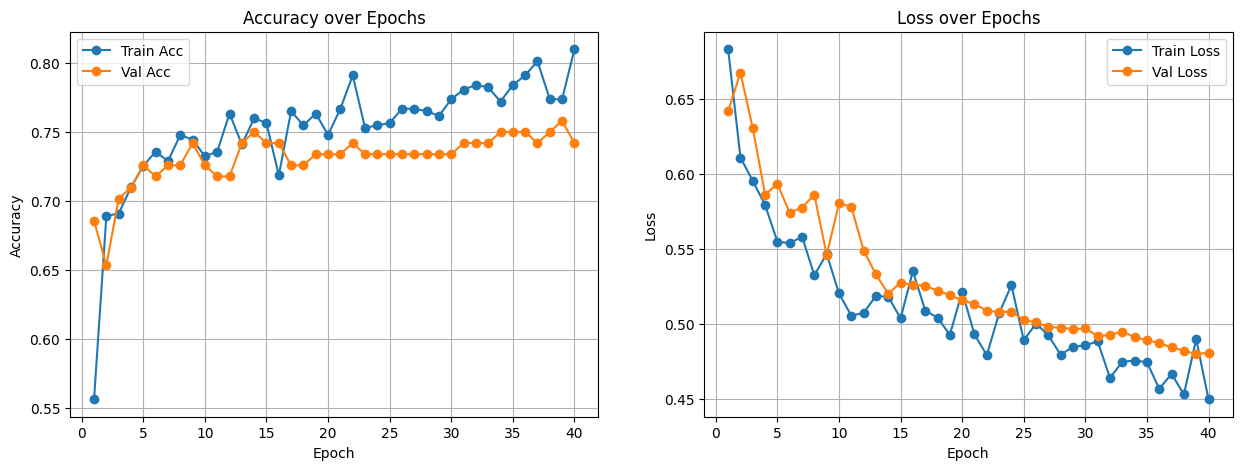

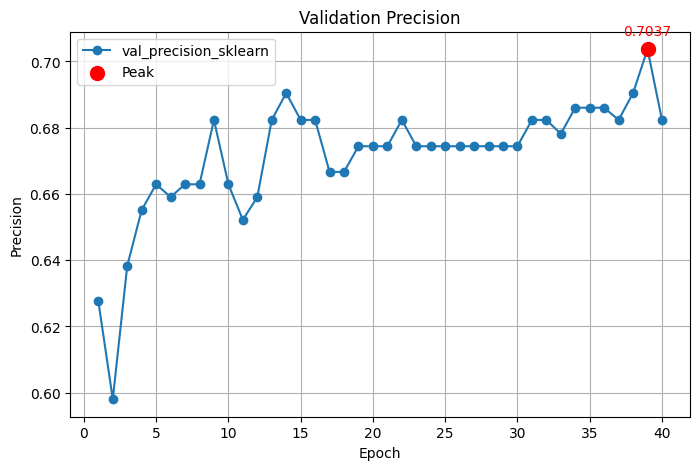

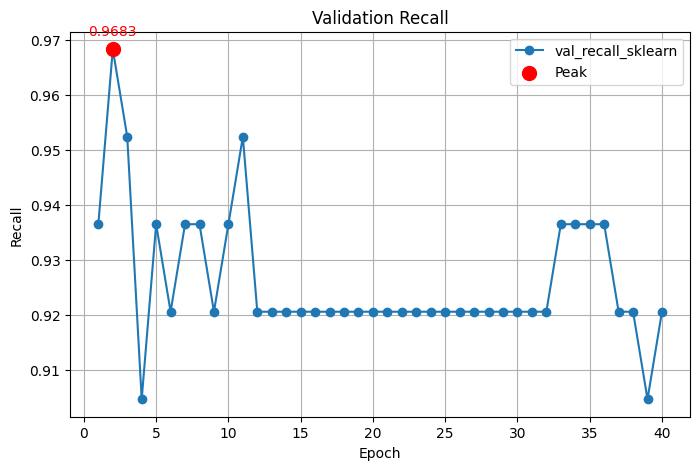

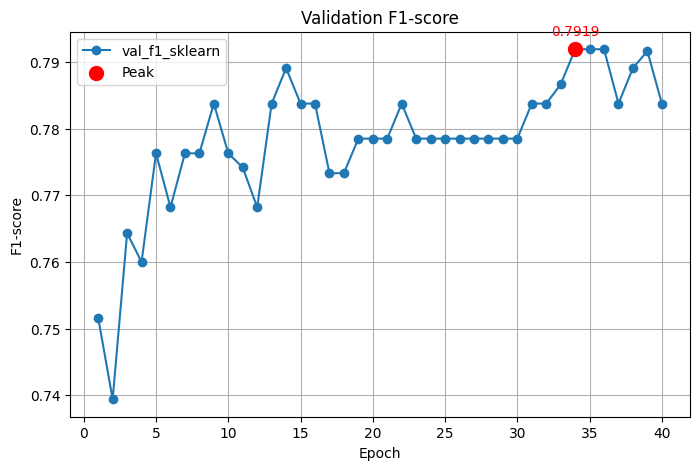

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step
===== FINAL TEST METRICS =====
Accuracy  : 0.8000
ROC-AUC   : 0.9019
Precision : 0.7532
Recall    : 0.9062
F1-score  : 0.8227

Classification Report:
               precision    recall  f1-score   support

      Normal       0.88      0.69      0.77        61
Osteoporosis       0.75      0.91      0.82        64

    accuracy                           0.80       125
   macro avg       0.81      0.80      0.80       125
weighted avg       0.81      0.80      0.80       125



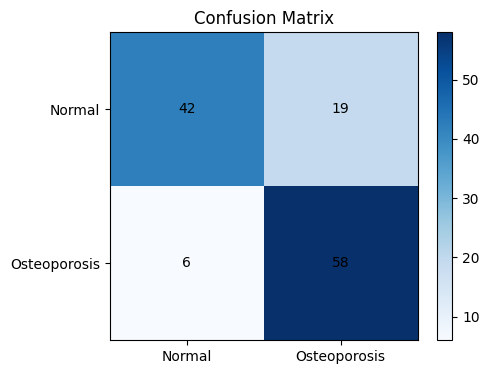

In [ ]:
# ============================================================
# FINAL PLOT & EVALUATION BLOCK
# ============================================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Combine histories from both training stages
H_all = {}
for key in set(list(history_1.history.keys()) + list(history_2.history.keys())):
    H_all[key] = history_1.history.get(key, []) + history_2.history.get(key, [])

epochs = np.arange(1, len(H_all['loss']) + 1)

# -------------------------------
# 1️⃣ Plot Training & Validation Accuracy and Loss
# -------------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, H_all['accuracy'], label='Train Acc', marker='o')
plt.plot(epochs, H_all['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, H_all['loss'], label='Train Loss', marker='o')
plt.plot(epochs, H_all['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# -------------------------------
#  Plot Validation Precision, Recall, F1
# -------------------------------
def plot_metric(key, title):
    if key in H_all and len(H_all[key]) > 0:
        plt.figure(figsize=(8,5))
        plt.plot(epochs, H_all[key], marker='o', label=key)
        best_idx = np.argmax(H_all[key])
        plt.scatter(epochs[best_idx], H_all[key][best_idx], color="red", s=100, zorder=5, label="Peak")
        plt.annotate(f"{H_all[key][best_idx]:.4f}",
                     (epochs[best_idx], H_all[key][best_idx]),
                     textcoords="offset points", xytext=(0,10), ha='center', color="red")
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(title.split()[1])
        plt.legend(); plt.grid(True); plt.show()
    else:
        print(f"{key} not found in history!")

plot_metric('val_precision_sklearn', 'Validation Precision')
plot_metric('val_recall_sklearn',    'Validation Recall')
plot_metric('val_f1_sklearn',        'Validation F1-score')

# -------------------------------
# Final Evaluation on Test Set
# -------------------------------
y_true = test_df['label'].values
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Compute metrics
test_accuracy = np.mean(y_pred == y_true)
roc_auc = roc_auc_score(y_true, y_prob)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("===== FINAL TEST METRICS =====")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Normal','Osteoporosis']))

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks([0,1], ['Normal','Osteoporosis'])
plt.yticks([0,1], ['Normal','Osteoporosis'])
for i in range(2):
    for j in range(2):
        plt.text(j,i, cm[i,j], ha='center', va='center', color='black')
plt.title("Confusion Matrix")
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step


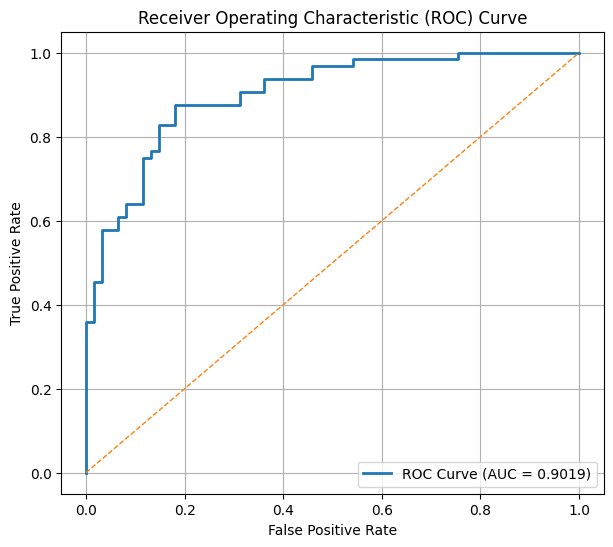

In [19]:
# ============================================================
# ROC CURVE PLOT (TEST SET)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ------------------------------------------------------------
# 1) GET TRUE LABELS & PREDICTED PROBABILITIES
# ------------------------------------------------------------
y_true = test_df['label'].values              # Ground truth
y_prob = model.predict(test_gen).ravel()      # Predicted probabilities

# ------------------------------------------------------------
# 2) COMPUTE ROC CURVE & AUC
# ------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# ------------------------------------------------------------
# 3) PLOT ROC CURVE
# ------------------------------------------------------------
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)  # Random classifier

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [20]:
# ============================================================
# A–Z GRAD-CAM++ (SINGLE BLOCK, READY TO RUN)
# ============================================================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# ------------------------------------------------------------
# 1) LOAD & PREPROCESS IMAGE
# ------------------------------------------------------------
def load_image(img_path, img_size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return img, np.expand_dims(img_arr, axis=0)

# ------------------------------------------------------------
# 2) GRAD-CAM++ FUNCTION (BINARY SAFE)
# ------------------------------------------------------------
def grad_cam_plus_plus(model, img_array, layer_name):
    conv_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        loss = preds[:, 0]  # sigmoid output

    grads = tape.gradient(loss, conv_out)

    first  = grads
    second = grads ** 2
    third  = grads ** 3

    global_sum = tf.reduce_sum(conv_out, axis=(0, 1, 2))

    alpha_num = second
    alpha_denom = 2 * second + third * global_sum
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    weights = tf.reduce_sum(alphas * tf.nn.relu(first), axis=(0, 1, 2))

    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)

    return cam.numpy()

# ------------------------------------------------------------
# 3) HEATMAP OVERLAY
# ------------------------------------------------------------
def overlay_heatmap(image, heatmap, alpha=0.45):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

# ------------------------------------------------------------
# 4) SELECT LAST CONV LAYER
# ------------------------------------------------------------
LAST_CONV_LAYER = "conv5_block16_concat"   # DenseNet121
# LAST_CONV_LAYER = "top_conv"             # EfficientNetB0




/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_678']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


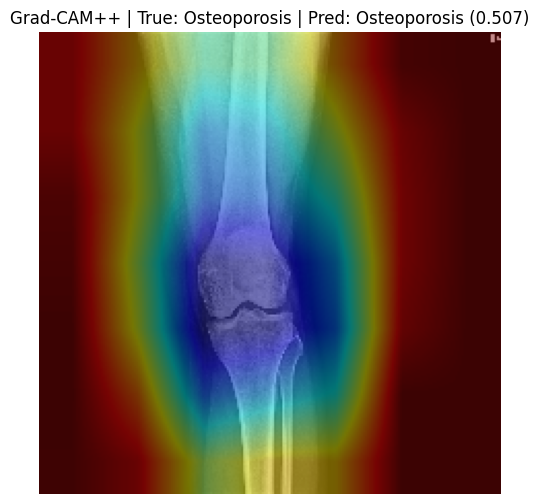

In [21]:
# ------------------------------------------------------------
# 5) RUN GRAD-CAM++ ON TEST IMAGE
# ------------------------------------------------------------
idx = 0
img_path = test_df.iloc[idx]['path']
true_label = test_df.iloc[idx]['label']

img, img_array = load_image(img_path, IMG_SIZE)

prob = model.predict(img_array, verbose=0)[0][0]
pred_label = "Osteoporosis" if prob >= 0.5 else "Normal"

heatmap = grad_cam_plus_plus(model, img_array, LAST_CONV_LAYER)
overlay = overlay_heatmap(np.array(img), heatmap)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis("off")
plt.title(f"Grad-CAM++ | True: {'Osteoporosis' if true_label else 'Normal'} | "
          f"Pred: {pred_label} ({prob:.3f})")
plt.show()

In [22]:
# ============================================================
# UPLOAD IMAGE & RUN GRAD-CAM++ (READY-TO-USE)
# ============================================================

from google.colab import files
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

# ------------------------------------------------------------
# 1) LOAD & PREPROCESS IMAGE
# ------------------------------------------------------------
def load_image(img_path, img_size):
    img = keras_image.load_img(img_path, target_size=img_size)
    img_array = keras_image.img_to_array(img)/255.0
    return img, np.expand_dims(img_array, axis=0)

# ------------------------------------------------------------
# 2) GRAD-CAM++ FUNCTION
# ------------------------------------------------------------
def grad_cam_plus_plus(model, img_array, layer_name):
    conv_layer = model.get_layer(layer_name)
    grad_model = Model(model.inputs, [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_out)

    first  = grads
    second = grads ** 2
    third  = grads ** 3
    global_sum = tf.reduce_sum(conv_out, axis=(0,1,2))

    alpha_num = second
    alpha_denom = 2*second + third*global_sum
    alpha_denom = tf.where(alpha_denom != 0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom

    weights = tf.reduce_sum(alphas * tf.nn.relu(first), axis=(0,1,2))
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam)+1e-8)
    return cam.numpy()

# ------------------------------------------------------------
# 3) HEATMAP OVERLAY
# ------------------------------------------------------------
def overlay_heatmap(image, heatmap, alpha=0.45):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(image.astype(np.uint8), 1-alpha, heatmap, alpha, 0)

# ------------------------------------------------------------
# 4) FIND LAST CONV LAYER
# ------------------------------------------------------------
LAST_CONV_LAYER = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        LAST_CONV_LAYER = layer.name
        break
print("Using last conv layer:", LAST_CONV_LAYER)



Using last conv layer: top_conv


Saving OS_24.png to OS_24.png


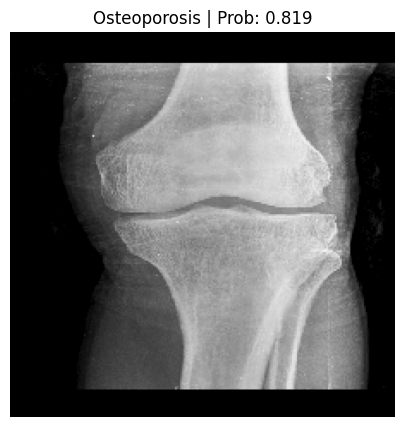

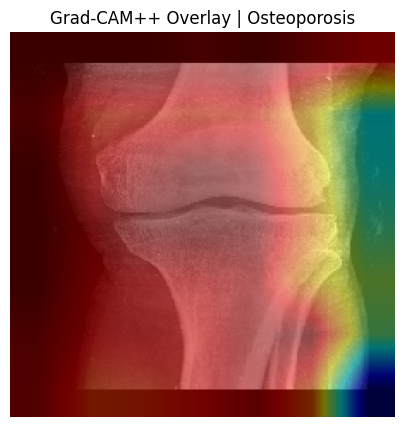

In [23]:
# ------------------------------------------------------------
# 5) UPLOAD AND TEST IMAGE
# ------------------------------------------------------------
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = os.path.join("/content", filename)
    img, img_array = load_image(img_path, IMG_SIZE)

    # Predict
    prob = model.predict(img_array, verbose=0)[0][0]
    label = "Osteoporosis" if prob >= 0.5 else "Normal"

    # Show original image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} | Prob: {prob:.3f}")
    plt.show()

    # Grad-CAM++ overlay
    heatmap = grad_cam_plus_plus(model, img_array, LAST_CONV_LAYER)
    overlay = overlay_heatmap(np.array(img), heatmap)

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM++ Overlay | {label}")
    plt.show()


Saving N_8.jpg to N_8.jpg


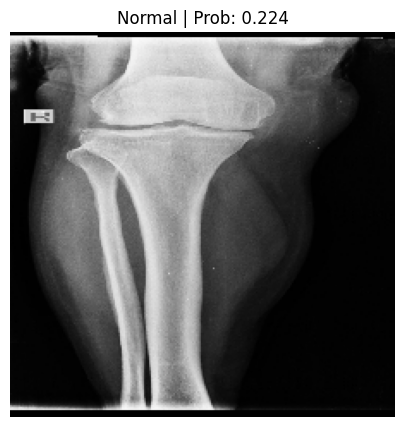

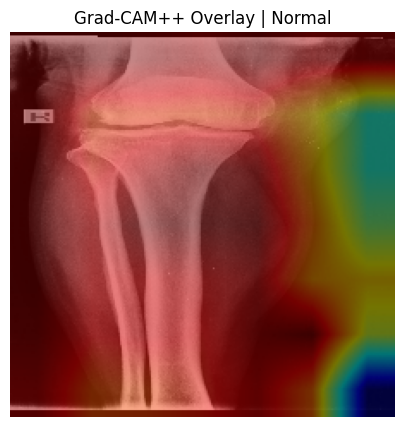

In [24]:
# ------------------------------------------------------------
# 5) UPLOAD AND TEST IMAGE
# ------------------------------------------------------------
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = os.path.join("/content", filename)
    img, img_array = load_image(img_path, IMG_SIZE)

    # Predict
    prob = model.predict(img_array, verbose=0)[0][0]
    label = "Osteoporosis" if prob >= 0.5 else "Normal"

    # Show original image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} | Prob: {prob:.3f}")
    plt.show()

    # Grad-CAM++ overlay
    heatmap = grad_cam_plus_plus(model, img_array, LAST_CONV_LAYER)
    overlay = overlay_heatmap(np.array(img), heatmap)

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(f"Grad-CAM++ Overlay | {label}")
    plt.show()


Saving N_8.jpg to N_8 (5).jpg


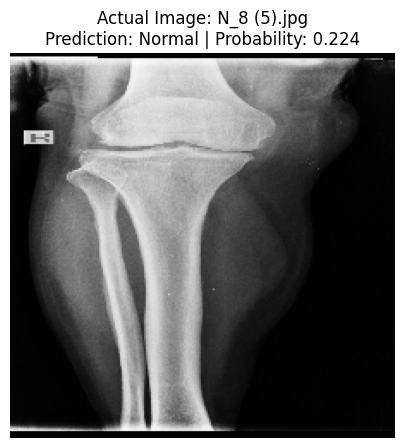

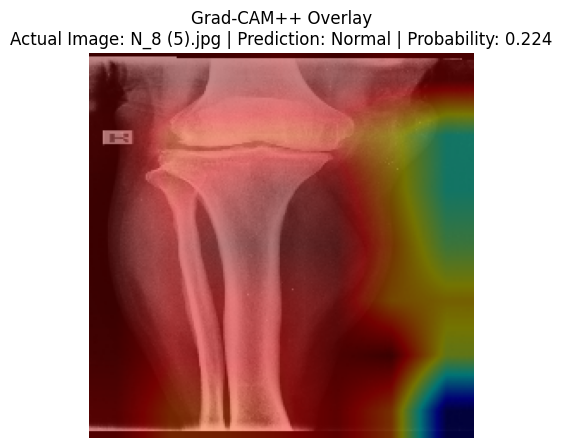

In [29]:
# ------------------------------------------------------------
# 5) UPLOAD AND TEST IMAGE
# ------------------------------------------------------------
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = os.path.join("/content", filename)
    img, img_array = load_image(img_path, IMG_SIZE)

    # Predict
    prob = model.predict(img_array, verbose=0)[0][0]
    label = "Osteoporosis" if prob >= 0.5 else "Normal"

    # =========================
    # Show original image
    # =========================
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Actual Image: {filename}\n"
        f"Prediction: {label} | Probability: {prob:.3f}"
    )
    plt.show()

    # =========================
    # Grad-CAM++ overlay
    # =========================
    heatmap = grad_cam_plus_plus(model, img_array, LAST_CONV_LAYER)
    overlay = overlay_heatmap(np.array(img), heatmap)

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(
        f"Grad-CAM++ Overlay\n"
        f"Actual Image: {filename} | Prediction: {label} | Probability: {prob:.3f}"
    )
    plt.show()


Saving OS_24.png to OS_24 (1).png


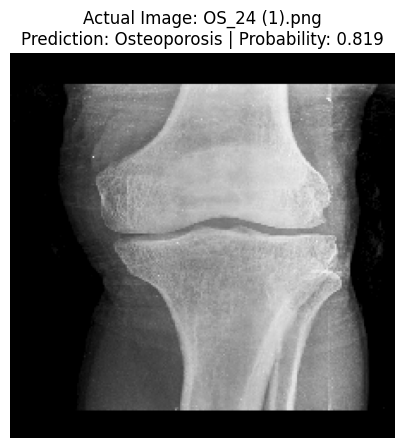

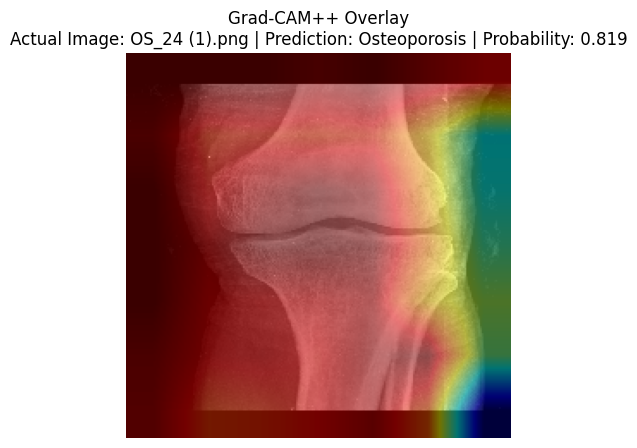

In [30]:
# ------------------------------------------------------------
# 5) UPLOAD AND TEST IMAGE
# ------------------------------------------------------------
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = os.path.join("/content", filename)
    img, img_array = load_image(img_path, IMG_SIZE)

    # Predict
    prob = model.predict(img_array, verbose=0)[0][0]
    label = "Osteoporosis" if prob >= 0.5 else "Normal"

    # =========================
    # Show original image
    # =========================
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Actual Image: {filename}\n"
        f"Prediction: {label} | Probability: {prob:.3f}"
    )
    plt.show()

    # =========================
    # Grad-CAM++ overlay
    # =========================
    heatmap = grad_cam_plus_plus(model, img_array, LAST_CONV_LAYER)
    overlay = overlay_heatmap(np.array(img), heatmap)

    plt.figure(figsize=(5,5))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(
        f"Grad-CAM++ Overlay\n"
        f"Actual Image: {filename} | Prediction: {label} | Probability: {prob:.3f}"
    )
    plt.show()
